## 0.Computer Vision Libraries in PyTorch

In [78]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(torch.__version__)
print(torchvision.__version__)

2.5.0+cu121
0.20.0+cu121


##1.Getting a dataset

In [79]:
# Set up training data
train_data = datasets.FashionMNIST(
    root = "data", # download data to
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

In [80]:
len(train_data), len(test_data)

(60000, 10000)

In [81]:
# See the first training example
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [82]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [83]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Input and output shapes of data

In [84]:
# Check the shapes of images
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [85]:
image.squeeze().shape

torch.Size([28, 28])

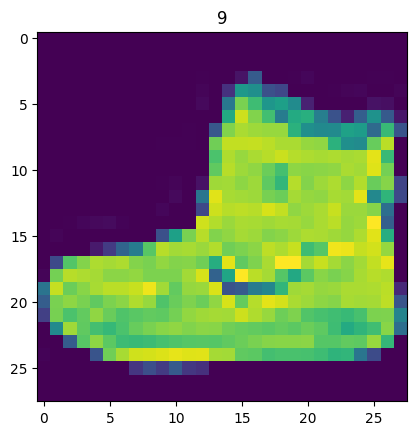

In [86]:
plt.imshow(image.squeeze());
plt.title(label);

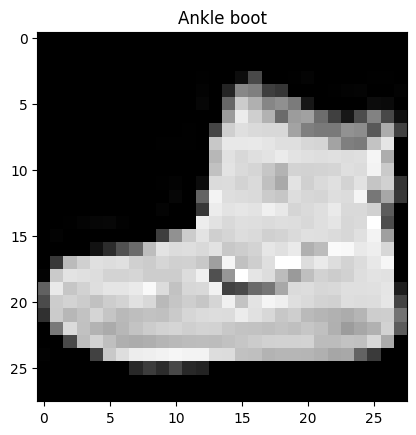

In [87]:
plt.imshow(image.squeeze(), cmap="gray");
plt.title(class_names[label]);

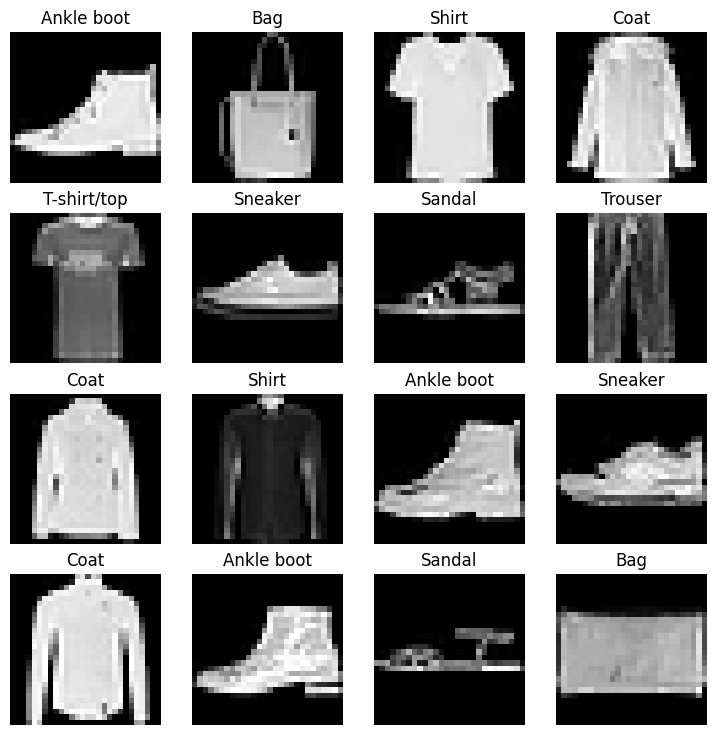

In [88]:
# Plot more images
#torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4

for i in range(1, rows * cols + 1) :
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)


## 2.Prepare Data Loader

In [89]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size= BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e0673011420>,
 <torch.utils.data.dataloader.DataLoader at 0x7e0673012740>)

In [90]:
# Lets check out what is created
print(f"Dataloaders : {train_dataloader, test_dataloader}")
print(f"Length of Train Dataloader : {len(train_dataloader)}")
print(f"Length of Test Dataloader : {len(test_dataloader)}")

Dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x7e0673011420>, <torch.utils.data.dataloader.DataLoader object at 0x7e0673012740>)
Length of Train Dataloader : 1875
Length of Test Dataloader : 313


In [91]:
# check out whats inside of train dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size : torch.Size([1, 28, 28])
Label: 5, Label_size: torch.Size([])


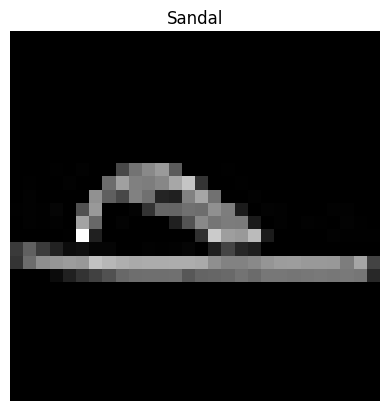

In [92]:
# Show samples
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image Size : {img.shape}")
print(f"Label: {label}, Label_size: {label.shape}")

## 3.Model_0 : Create Baseline Model

In [93]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sampel
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flatteninhg: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flatteninhg: torch.Size([1, 784])


In [94]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape : int,
               hidden_units : int,
               output_shape : int
               ):

    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)



In [95]:
torch.manual_seed(42)

# Setup the model
model_0 = FashionMNISTModelV0(
    input_shape = 784,
    hidden_units = 10,
    output_shape = len(class_names)
)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [96]:
dummy_x = torch.rand([1,1, 28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss and optimizers

In [97]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [98]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time our experiments

In [99]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Creating a training loop and training a model on batches of data

In [100]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the epochs
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n-----------")

  # Training
  train_loss = 0

  # Add a loop to loopthrough training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    # 1. forward pass
    y_pred = model_0(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()


    # Print
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader (average loss per batch per epoch)
  train_loss /= len(train_dataloader)


  ### testing
  test_loss, test_acc = 0, 0
  model_0.eval()

  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))

    # calculate the test loss avg per bacth
    test_loss /= len(test_dataloader)

    # calculate the test acc avg
    test_acc /= len(test_dataloader)

  # Print
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
-----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch : 1
-----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch : 2
-----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 30.172 seconds


## 4.Make predictions and get Model 0 results

In [101]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

### 5. Setup device agnostic-code (for using a GPU if there is one)

In [102]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1 : Building a better model with Non Linearity

In [103]:
# Create a model with linear and non linear layers
class FashionMNISTV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int ,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features= output_shape ),
        nn.ReLU()
    )

  def forward(self, x:torch.Tensor):
    return self.layer_stack(x)

In [104]:
# Create instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTV1(input_shape=784,
                         hidden_units = 10,
                         output_shape= len(class_names)).to(device)


In [105]:
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metric

In [106]:
# Import accuracy metric
from helper_functions import accuracy_fn

## Loss fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters() ,
                            lr = 0.1)

### 6.2 Functionizing training and test loops¶

In [107]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [108]:
torch.manual_seed(42)

## Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

## Set epochs
epochs = 3

# create a optimization and evaluation loop using functions
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch} \n------------")
  train_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             device = device,
             accuracy_fn = accuracy_fn
             )

  test_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
            device=device
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0 
------------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.92727 | Test accuracy: 66.00%

Epoch : 1 
------------
Train loss: 0.73779 | Train accuracy: 73.69%
Test loss: 0.68793 | Test accuracy: 75.43%

Epoch : 2 
------------
Train loss: 0.66776 | Train accuracy: 76.08%
Test loss: 0.64329 | Test accuracy: 76.87%

Train time on cuda: 58.725 seconds


In [109]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.6874349117279053,
 'model_acc': 75.65894568690096}

In [110]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 7. Model 2: Building a Convolutional Neural Network (CNN)

In [123]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """ Architecture of TinyVGG """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding =1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 *7,
                  out_features = output_shape)
    )


  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [124]:
torch.manual_seed(42)

# Model
model_2 = FashionMNISTModelV2(input_shape = 1, ## Color Channels
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1 Stepping through Conv2d layer

In [125]:
torch.manual_seed(42)

# Create batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image Batch Shape : {images.shape}")
print(f"Single Image Shape : {test_image.shape}")
print(f"\nTest Image : \n{test_image}")

Image Batch Shape : torch.Size([32, 3, 64, 64])
Single Image Shape : torch.Size([3, 64, 64])

Test Image : 
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        

In [126]:
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 0
                       )

## Pass the data through conv layer
conv_op = conv_layer(test_image)
conv_op

tensor([[[-2.8778e-01, -6.0596e-02, -5.6306e-02,  ...,  2.8654e-01,
           6.6224e-01, -2.3216e-01],
         [-9.8911e-01, -4.0099e-01,  4.1832e-01,  ...,  4.7459e-01,
          -1.8552e-01, -5.7622e-01],
         [-4.1340e-02, -2.3277e-01,  3.7418e-01,  ...,  2.8255e-02,
           1.4923e-01,  1.4236e-01],
         ...,
         [-8.0374e-01, -7.6687e-01, -5.9457e-02,  ...,  1.7452e-01,
           4.2594e-01, -4.8341e-01],
         [-1.4512e-01, -1.1566e-01,  6.1783e-01,  ...,  2.4126e-01,
          -3.6626e-01,  3.5645e-01],
         [ 3.6096e-02,  1.5214e-01,  2.3123e-01,  ...,  3.0904e-01,
          -4.9680e-01, -7.2258e-01]],

        [[-1.0853e+00, -1.6079e+00,  1.3346e-01,  ...,  2.1698e-01,
          -1.7643e+00,  2.5263e-01],
         [-8.2507e-01,  6.3866e-01,  1.8845e-01,  ..., -1.0936e-01,
           4.8068e-01,  8.4869e-01],
         [ 6.4927e-01, -4.2061e-03, -4.9991e-01,  ...,  5.8356e-01,
           2.4611e-01,  6.6233e-01],
         ...,
         [ 9.8860e-02,  1

In [127]:
conv_op.shape

torch.Size([10, 62, 62])

### 7.2 Stepping through nn.MaxPool2d

In [128]:
# without unsqueezed
test_image.shape

torch.Size([3, 64, 64])

In [129]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [130]:
# Test image through conv
conv_op = conv_layer(test_image.unsqueeze(0))
conv_op.shape

torch.Size([1, 10, 62, 62])

In [131]:
# Pass data through max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2 )
max_pool_op = max_pool_layer(conv_op)
max_pool_op.shape

torch.Size([1, 10, 31, 31])

### 7.3 Loss Function and Optimizer


In [132]:
# Setup loss fn
from helper_functions import accuracy_fn

loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr = 0.1, params = model_2.parameters())

### 7.4 Training and testing

In [133]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n-----------")
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn ,
             optimizer = optimizer, accuracy_fn = accuracy_fn,
             device = device
             )

  test_step(model = model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            device = device,
            accuracy_fn = accuracy_fn)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                            end = train_time_end_model_2,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
-----------
Train loss: 0.59424 | Train accuracy: 78.38%
Test loss: 0.39103 | Test accuracy: 85.99%

Epoch : 1
-----------
Train loss: 0.36295 | Train accuracy: 86.93%
Test loss: 0.35539 | Test accuracy: 86.67%

Epoch : 2
-----------
Train loss: 0.32446 | Train accuracy: 88.31%
Test loss: 0.32439 | Test accuracy: 88.32%

Train time on cuda: 35.885 seconds


In [137]:
# Model 2 results
model_2_results = eval_model(
    model = model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn,
    device= device
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3243867754936218,
 'model_acc': 88.31869009584665}

In [138]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 8. Compare model results and training time

In [142]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                              model_1_results,
                              model_2_results])

In [143]:
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTV1,0.687435,75.658946
2,FashionMNISTModelV2,0.324387,88.318690


In [145]:
### add training time to result comparison
compare_results["Training Time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,Training Time
0,FashionMNISTModelV0,0.476639,83.426518,30.171568
1,FashionMNISTV1,0.687435,75.658946,58.725398
2,FashionMNISTModelV2,0.324387,88.318690,35.884697


## 9. Make and Evaluate Random Predictions with Best Model

In [146]:
def make_predictions(model : torch.nn.Module,
                     data : int,
                     device : torch.device = device
                     ):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get pred prob
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob of gpu for further calculation
      pred_probs.append(pred_prob.cpu())

  # stack the pred_prob to turn list onto tesor\
  return torch.stack(pred_probs)

In [158]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View rhe first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

In [159]:
# Make Predictions
pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# View the forst two prediction probs
pred_probs[:2]

tensor([[6.9655e-07, 1.9705e-06, 1.9317e-06, 1.1835e-05, 6.6102e-06, 9.9940e-01,
         1.9001e-06, 2.5908e-04, 4.3049e-05, 2.7395e-04],
        [6.6871e-03, 8.2910e-06, 3.6257e-02, 6.5556e-04, 6.3366e-02, 7.9365e-06,
         8.9281e-01, 1.1636e-06, 2.0205e-04, 1.3394e-06]])

In [160]:
# Convert pred probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 6, 6, 6, 3, 1, 2, 3, 6])

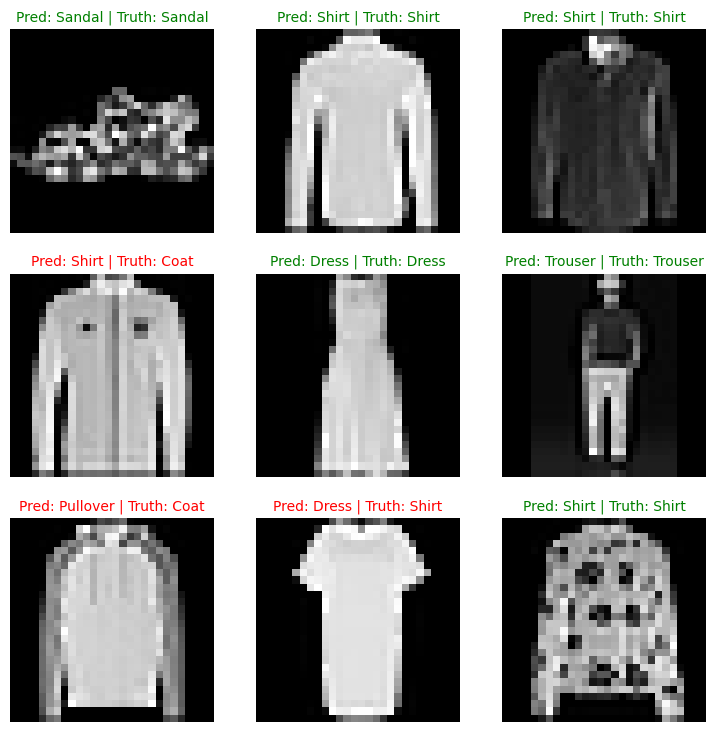

In [161]:
# Plot preds
plt.figure(figsize = (9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  # Plt image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create the title for plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Change color
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

In [162]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [163]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 21.9 MB/s eta 0:00:00
mlxtend version: 0.23.2


In [164]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.2


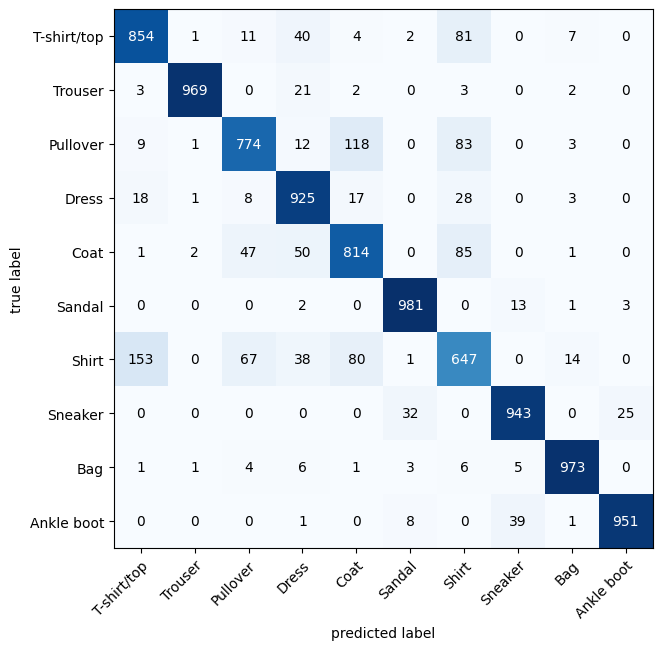

In [165]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 11. Save and load best performing model

In [166]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [167]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

<ipython-input-167-01e1a5266d0e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [168]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3243867754936218,
 'model_acc': 88.31869009584665}

In [169]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3243867754936218,
 'model_acc': 88.31869009584665}

In [170]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)